In [3]:
import os 
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
from pyarrow import feather
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import entropy


plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = (10, 10)

In [5]:
#move up in directory
os.chdir('../')

from helpers import dot2_

In [42]:
os.getcwd()

'C:\\Users\\Bio_Psych\\Desktop\\Deniz\\tf-cpu\\p1_generalization'

In [18]:
rel_rew_arr = []
acc_arr = []
n_bins = 10

### lSTM

for id_ in range(20):
    for walk in range(1,4):
        d = pickle.load(open('data\\rnn_raw_data\\lstm2_a2c_nh_48_lr_0_0001_n_u_p_0_5_ew_lin_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}'.format(id_, walk), 'rb'))
        df_lstm = d.reset_index()
        df = d.reset_index()


        best_reward = np.array(np.max(df[['p_rew_1', 'p_rew_2', 'p_rew_3', 'p_rew_4']], axis = 1))
        rel_reward = [best_reward[t] -  np.mean(np.array([p1, p2, p3, p4])[[[p1,p2,p3,p4]!=best_reward[t]]]) for t, p1, p2, p3, p4 in zip(range(len(best_reward)), df['p_rew_1'], df['p_rew_2'], df['p_rew_3'], df['p_rew_4'])]
        
        rel_reward = np.multiply(rel_reward,100)
        
        rel_rew_arr.extend(rel_reward)
        acc_arr.extend(df['accuracy'].values)

### Human        

path_to_data = 'data/human_raw_data/'
data_file = 'data_chakroun_wiehler.csv'
human_df = pd.read_csv(open(path_to_data + data_file, 'rb'), index_col=0)

rel_rew_arr_hum = []
acc_arr_hum = []

for sub in range(1, 32):
        df = human_df[human_df['vp'].values==sub]
        
        best_reward = np.array(np.max(df[['reward_b1', 'reward_b2', 'reward_b3', 'reward_b4']], axis = 1))
        
        accuracy = [int((ch-1)==np.argmax([p1,p2,p3,p4])) for ch, p1, p2, p3, p4 in zip(df['choice'], df['reward_b1'], df['reward_b2'], df['reward_b3'], df['reward_b4'])]
        
        rel_reward = [best_reward[t] -  np.mean(np.array([p1, p2, p3, p4])[[[p1,p2,p3,p4]!=best_reward[t]]]) for t, p1, p2, p3, p4 in zip(range(len(best_reward)), df['reward_b1'], df['reward_b2'], df['reward_b3'], df['reward_b4'])]

        rel_rew_arr_hum.extend(rel_reward)
        acc_arr_hum.extend(accuracy)
        



C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  from ipykernel import kernelapp as app
C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [19]:
# create df
df = pd.DataFrame({'rel_rew': rel_rew_arr + rel_rew_arr_hum, 'acc': acc_arr + acc_arr_hum, 'type': ['lstm'] * len(rel_rew_arr) + ['human'] * len(rel_rew_arr_hum)})

# create bins
df['rel_rew_bins'] = pd.qcut(df['rel_rew'], q=n_bins)

print('human bin counts')
print(df[df['type'] == 'human'].value_counts('rel_rew_bins'))

print('lstm bin counts')
print(df[df['type'] == 'lstm'].value_counts('rel_rew_bins'))


plot_df = df.groupby(['rel_rew_bins', 'type']).mean().reset_index()

human bin counts
rel_rew_bins
(2.612, 9.58]       954
(18.084, 20.291]    941
(12.739, 15.102]    933
(29.943, 37.945]    930
(25.984, 29.943]    930
(37.945, 52.819]    926
(22.672, 25.984]    924
(20.291, 22.672]    921
(9.58, 12.739]      921
(15.102, 18.084]    920
dtype: int64
lstm bin counts
rel_rew_bins
(9.58, 12.739]      1820
(37.945, 52.819]    1800
(29.943, 37.945]    1800
(25.984, 29.943]    1800
(22.672, 25.984]    1800
(20.291, 22.672]    1800
(18.084, 20.291]    1800
(15.102, 18.084]    1800
(12.739, 15.102]    1800
(2.612, 9.58]       1780
dtype: int64


# logistic regression/psychometric curves

In [20]:
log_reg = sm.Logit(df[df['type'] == 'lstm']['acc'].values, df[df['type'] == 'lstm']['rel_rew'].values).fit()
print('lstm')
print(log_reg.summary())

x_rel_rew = np.linspace(0, 50, 1000)
y_lstm = log_reg.predict(x_rel_rew )

print('human')
log_reg = sm.Logit(df[df['type'] == 'human']['acc'].values, df[df['type'] == 'human']['rel_rew'].values).fit()
print(log_reg.summary())

y_human = log_reg.predict(x_rel_rew )

Optimization terminated successfully.
         Current function value: 0.650980
         Iterations 4
lstm
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                18000
Model:                          Logit   Df Residuals:                    17999
Method:                           MLE   Df Model:                            0
Date:                Fri, 12 Aug 2022   Pseudo R-squ.:                 0.03066
Time:                        15:08:23   Log-Likelihood:                -11718.
converged:                       True   LL-Null:                       -12088.
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0252      0.001     37.493      0.000       0.024       0.026
human
Optimization termi

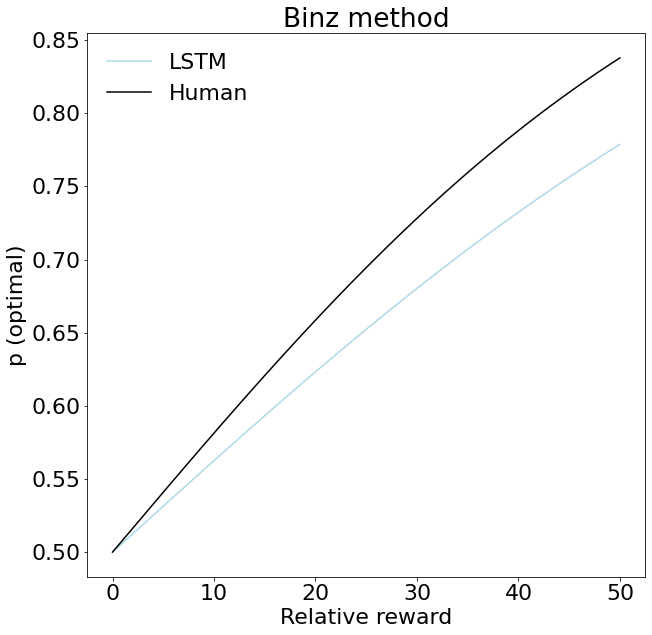

In [21]:
plt.plot(x_rel_rew, y_lstm, color='lightblue', label = 'LSTM')
plt.plot(x_rel_rew, y_human, color='black', label = 'Human')
plt.ylabel('p (optimal)')
plt.xlabel('Relative reward')
plt.title('Binz method')
plt.legend(frameon=False)

Text(0.5, 0, 'Relative reward')

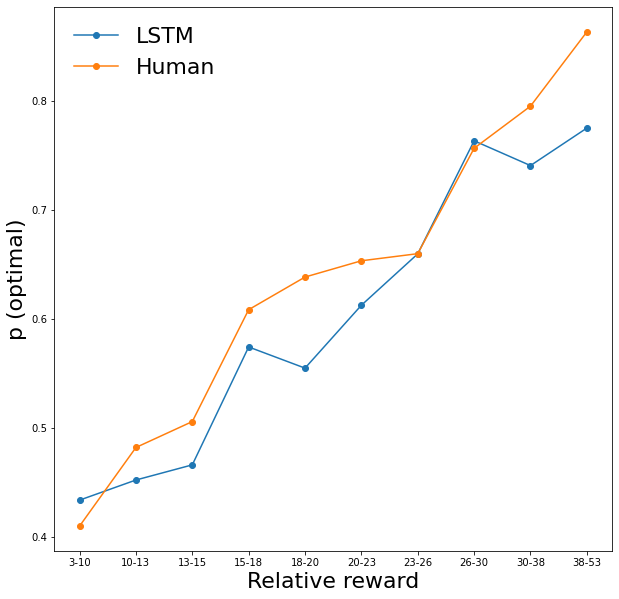

In [63]:
rr_bins = np.unique(plot_df['rel_rew_bins'])

my_ticks = [str(np.round(rr_bins[t].left)).replace('.0', '') + '-' + str(np.round(rr_bins[t].right)).replace('.0', '') for t in range(len(rr_bins))] 


plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=8)

plt.plot(range(len(plot_df[plot_df['type']=='lstm']['acc'])), plot_df[plot_df['type']=='lstm']['acc'], '-o', label = 'LSTM')

plt.plot(range(len(plot_df[plot_df['type']=='human']['acc'])), plot_df[plot_df['type']=='human']['acc'], '-o', label = 'Human')

plt.xticks(range(10), my_ticks)

plt.legend(frameon = False)

plt.ylabel('p (optimal)')
plt.xlabel('Relative reward')

# Uncertainty

In [17]:
# calculate uncertainty for options

def get_uncertainty(index, unc_vec):
    
    trials = np.arange(0,300,1)
    trials[index] = 0

    for t, unc in enumerate(unc_vec):

        if t ==0:
            trials[:index[t]] = np.arange(1,index[t]+1, 1)

        else: 
            trials[index[t-1]+1:index[t]] = np.arange(1,unc+1, 1)
            
        if t == len(unc_vec)-1 and index[t] < len(trials)-1:
            
#             pdb.set_trace()
            
            trials[index[t]+1:] = np.arange(1,(len(trials)-index[t]), 1)
            
    return(trials)



In [43]:
# for stay/switch predictions
lagged_unc_arr = []
switch_arr = []

# for action specific predictions
actions_1 = []
actions_2 = []
actions_3 = []
actions_4 = []

switch_lagged_unc_1_arr = []
switch_lagged_unc_2_arr = []
switch_lagged_unc_3_arr = []
switch_lagged_unc_4_arr = []


### lSTM

for id_ in range(20):
    for walk in range(1,4):
        d = pickle.load(open('data\\rnn_raw_data\\lstm2_a2c_nh_48_lr_0_0001_n_u_p_0_5_ew_lin_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}'.format(id_, walk), 'rb'))
        df_lstm = d.reset_index()
        
        one_index = np.where(df_lstm['choice'].values == 0)[0]
        unc_one = one_index - (pd.Series(one_index).shift(1).values +1)

        two_index = np.where(df_lstm['choice'].values == 1)[0]
        unc_two = two_index - (pd.Series(two_index).shift(1).values +1)

        three_index = np.where(df_lstm['choice'].values == 2)[0]
        unc_three = three_index - (pd.Series(three_index).shift(1).values +1)

        four_index = np.where(df_lstm['choice'].values == 3)[0]
        unc_four = four_index - (pd.Series(four_index).shift(1).values +1)

        # function call
        unc_1 = get_uncertainty(one_index, unc_one)
        unc_2 = get_uncertainty(two_index, unc_two)
        unc_3 = get_uncertainty(three_index, unc_three)
        unc_4 = get_uncertainty(four_index, unc_four)
        
        # subset uncertainty prior to choice
        lagged_unc_1 = pd.Series(unc_1).shift(1).values
        lagged_unc_2 = pd.Series(unc_2).shift(1).values
        lagged_unc_3 = pd.Series(unc_3).shift(1).values
        lagged_unc_4 = pd.Series(unc_4).shift(1).values
        
        # get all switches
        switch_df = df_lstm[df_lstm['is_switch']==1]

        # get binary variable for action a
        action_1 = switch_df['choice']==0
        action_2 = switch_df['choice']==1
        action_3 = switch_df['choice']==2
        action_4 = switch_df['choice']==3

        # get lagged relative uncertainty for action a
        switch_lagged_unc_1 = lagged_unc_1[np.array(switch_df.index)]
        switch_lagged_unc_2 = lagged_unc_2[np.array(switch_df.index)]
        switch_lagged_unc_3 = lagged_unc_3[np.array(switch_df.index)]
        switch_lagged_unc_4 = lagged_unc_4[np.array(switch_df.index)]


        lagged_ch_unc = [[u_1,u_2,u_3,u_4][ch] -  np.mean([u_1,u_2,u_3,u_4]) for ch, u_1,u_2,u_3,u_4 in zip(df_lstm['choice'], lagged_unc_1, lagged_unc_2, lagged_unc_3,lagged_unc_4)]
        
        # add to result lists
        lagged_unc_arr.extend(lagged_ch_unc)
        switch_arr.extend(df_lstm['is_switch'].values)
        
        actions_1.extend(action_1)
        actions_2.extend(action_2)
        actions_3.extend(action_3)
        actions_4.extend(action_4)
        
        switch_lagged_unc_1_arr.extend(switch_lagged_unc_1)
        switch_lagged_unc_2_arr.extend(switch_lagged_unc_2)
        switch_lagged_unc_3_arr.extend(switch_lagged_unc_3)
        switch_lagged_unc_4_arr.extend(switch_lagged_unc_4)


Text(0, 0.5, '% switch')

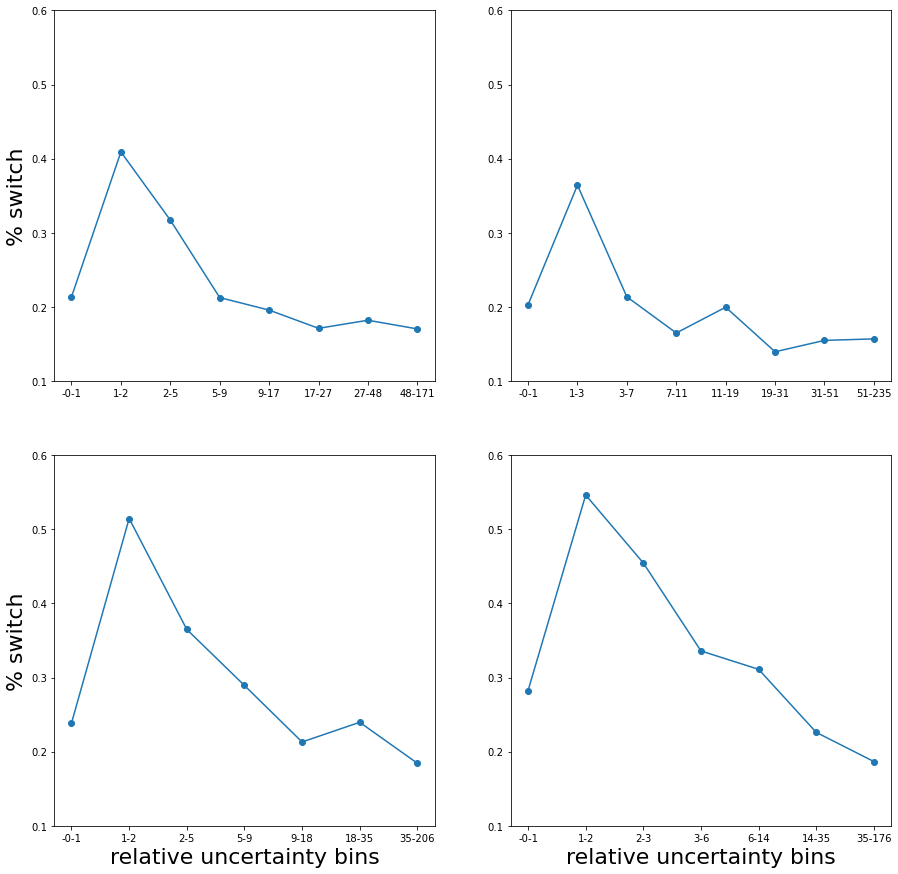

In [41]:
unc_df = pd.DataFrame({'actions_1': actions_1, 'actions_2': actions_2, 'actions_3': actions_3, 'actions_4': actions_4,
                      'lagged_unc_1': switch_lagged_unc_1_arr, 'lagged_unc_2': switch_lagged_unc_2_arr, 'lagged_unc_3': switch_lagged_unc_3_arr, 'lagged_unc_4': switch_lagged_unc_4_arr})

unc_df['lagged_unc_1_bins'] = pd.qcut(unc_df['lagged_unc_1'], q=10, duplicates = 'drop')
unc_df['lagged_unc_2_bins'] = pd.qcut(unc_df['lagged_unc_2'], q=10, duplicates = 'drop')
unc_df['lagged_unc_3_bins'] = pd.qcut(unc_df['lagged_unc_3'], q=10, duplicates = 'drop')
unc_df['lagged_unc_4_bins'] = pd.qcut(unc_df['lagged_unc_4'], q=10, duplicates = 'drop')



fig, ax = plt.subplots( 2,2)

fig.set_figheight(15)
fig.set_figwidth(15)



unc_plot_df = unc_df.groupby(['lagged_unc_1_bins']).mean()['actions_1']

rr_bins = unc_plot_df.index
my_ticks = [str(np.round(rr_bins[t].left)).replace('.0', '') + '-' + str(np.round(rr_bins[t].right)).replace('.0', '') for t in range(len(rr_bins))] 

ax[0,0].plot(range(np.shape(unc_plot_df)[0]),unc_plot_df.values, '-o')
ax[0,0].set_ylim([0.1, 0.6])
ax[0,0].set_xticks(range(8), my_ticks)
ax[0,0].tick_params(axis='both', which='major', labelsize=10)
ax[0,0].tick_params(axis='both', which='minor', labelsize=8)

unc_plot_df = unc_df.groupby(['lagged_unc_2_bins']).mean()['actions_2']

rr_bins = unc_plot_df.index
my_ticks = [str(np.round(rr_bins[t].left)).replace('.0', '') + '-' + str(np.round(rr_bins[t].right)).replace('.0', '') for t in range(len(rr_bins))] 

ax[0,1].plot(range(np.shape(unc_plot_df)[0]),unc_plot_df.values, '-o')
ax[0,1].set_ylim([0.1, 0.6])
ax[0,1].set_xticks(range(8), my_ticks)
ax[0,1].tick_params(axis='both', which='major', labelsize=10)
ax[0,1].tick_params(axis='both', which='minor', labelsize=8)

unc_plot_df = unc_df.groupby(['lagged_unc_3_bins']).mean()['actions_3']

rr_bins = unc_plot_df.index
my_ticks = [str(np.round(rr_bins[t].left)).replace('.0', '') + '-' + str(np.round(rr_bins[t].right)).replace('.0', '') for t in range(len(rr_bins))] 

ax[1,0].plot(range(np.shape(unc_plot_df)[0]),unc_plot_df.values, '-o')
ax[1,0].set_ylim([0.1, 0.6])
ax[1,0].set_xticks(range(7), my_ticks)
ax[1,0].tick_params(axis='both', which='major', labelsize=10)
ax[1,0].tick_params(axis='both', which='minor', labelsize=8)

unc_plot_df = unc_df.groupby(['lagged_unc_4_bins']).mean()['actions_4']

rr_bins = unc_plot_df.index
my_ticks = [str(np.round(rr_bins[t].left)).replace('.0', '') + '-' + str(np.round(rr_bins[t].right)).replace('.0', '') for t in range(len(rr_bins))] 


ax[1,1].plot(range(np.shape(unc_plot_df)[0]),unc_plot_df.values, '-o')
ax[1,1].set_ylim([0.1, 0.6])
ax[1,1].set_xticks(range(7), my_ticks)
ax[1,1].tick_params(axis='both', which='major', labelsize=10)
ax[1,1].tick_params(axis='both', which='minor', labelsize=8)

# labels

ax[1,1].set_xlabel('relative uncertainty bins')
ax[1,0].set_xlabel('relative uncertainty bins')

ax[0,0].set_ylabel('% switch')
ax[1,0].set_ylabel('% switch')

In [28]:
############################################
# calculate uncertainty for human subjects #
############################################

# for stay/switch predictions
lagged_unc_arr_h = []
switch_arr_h = []

# for action specific predictions
actions_1_h = []
actions_2_h = []
actions_3_h = []
actions_4_h = []

switch_lagged_unc_1_arr_h = []
switch_lagged_unc_2_arr_h = []
switch_lagged_unc_3_arr_h = []
switch_lagged_unc_4_arr_h = []

path_to_data = 'data/human_raw_data/'
data_file = 'data_chakroun_wiehler.csv'
human_df = pd.read_csv(open(path_to_data + data_file, 'rb'), index_col=0)

rel_rew_arr_hum = []
acc_arr_hum = []

for sub in range(1, 32):
    
    df_lstm = human_df[human_df['vp'].values==sub]
    df_lstm['choice'] = df_lstm['choice'].values-1

    one_index = np.where(df_lstm['choice'].values == 0)[0]
    unc_one = one_index - (pd.Series(one_index).shift(1).values +1)

    two_index = np.where(df_lstm['choice'].values == 1)[0]
    unc_two = two_index - (pd.Series(two_index).shift(1).values +1)

    three_index = np.where(df_lstm['choice'].values == 2)[0]
    unc_three = three_index - (pd.Series(three_index).shift(1).values +1)

    four_index = np.where(df_lstm['choice'].values == 3)[0]
    unc_four = four_index - (pd.Series(four_index).shift(1).values +1)

    # function call
    unc_1 = get_uncertainty(one_index, unc_one)
    unc_2 = get_uncertainty(two_index, unc_two)
    unc_3 = get_uncertainty(three_index, unc_three)
    unc_4 = get_uncertainty(four_index, unc_four)

    # subset uncertainty prior to choice
    lagged_unc_1 = pd.Series(unc_1).shift(1).values
    lagged_unc_2 = pd.Series(unc_2).shift(1).values
    lagged_unc_3 = pd.Series(unc_3).shift(1).values
    lagged_unc_4 = pd.Series(unc_4).shift(1).values

    # get all switches
    is_switch = [int(df_lstm['choice'].values[t] != df_lstm['choice'].values[t-1]) for t in range(1, len(df_lstm.choice))]
    is_switch = np.insert(is_switch, 0, 0) # insert leading 0, first element can't be switch
    df_lstm['is_switch'] = is_switch 
    switch_df = df_lstm[df_lstm['is_switch']==1]
    switch_df = switch_df.reset_index()

    # get binary variable for action a
    action_1 = switch_df['choice']==0
    action_2 = switch_df['choice']==1
    action_3 = switch_df['choice']==2
    action_4 = switch_df['choice']==3

    # get lagged relative uncertainty for action a
    switch_lagged_unc_1 = lagged_unc_1[np.array(switch_df.index)]
    switch_lagged_unc_2 = lagged_unc_2[np.array(switch_df.index)]
    switch_lagged_unc_3 = lagged_unc_3[np.array(switch_df.index)]
    switch_lagged_unc_4 = lagged_unc_4[np.array(switch_df.index)]


    lagged_ch_unc = [[u_1,u_2,u_3,u_4][ch] -  np.mean([u_1,u_2,u_3,u_4]) for ch, u_1,u_2,u_3,u_4 in zip(df_lstm['choice'], lagged_unc_1, lagged_unc_2, lagged_unc_3,lagged_unc_4)]

    # add to result lists
    lagged_unc_arr.extend(lagged_ch_unc)
    switch_arr.extend(df_lstm['is_switch'].values)

    actions_1.extend(action_1)
    actions_2.extend(action_2)
    actions_3.extend(action_3)
    actions_4.extend(action_4)

    switch_lagged_unc_1_arr.extend(switch_lagged_unc_1)
    switch_lagged_unc_2_arr.extend(switch_lagged_unc_2)
    switch_lagged_unc_3_arr.extend(switch_lagged_unc_3)
    switch_lagged_unc_4_arr.extend(switch_lagged_unc_4)



C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Bio_Psych\anaconda3\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

Text(0, 0.5, '% switch')

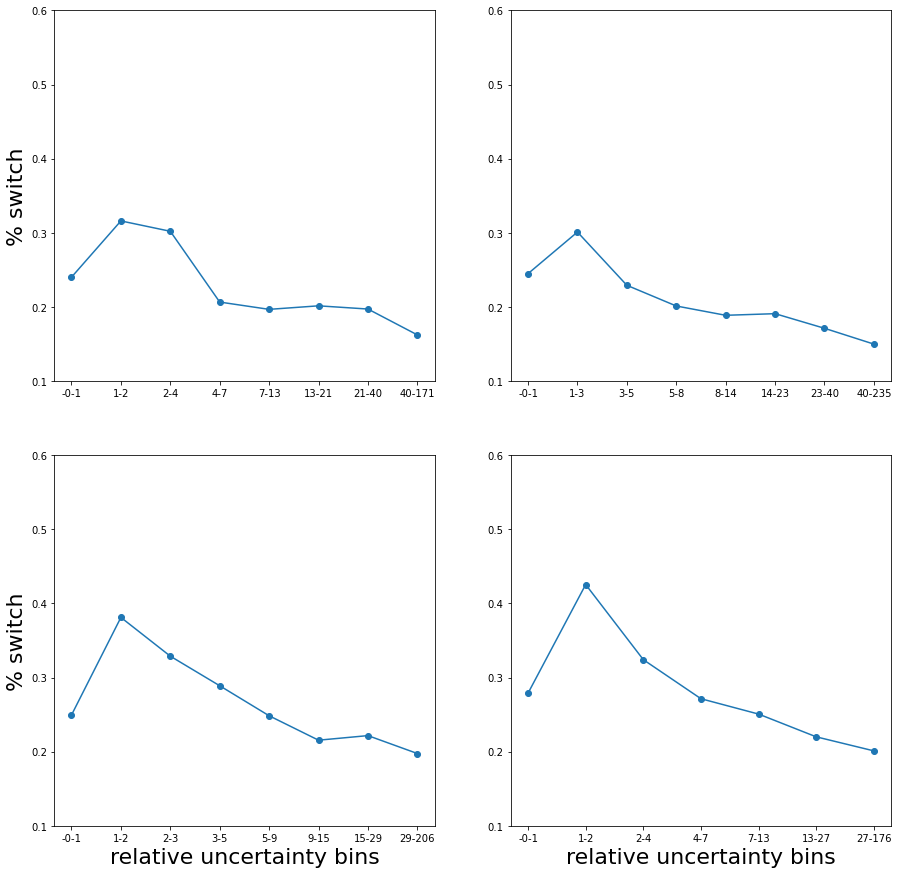

In [36]:
unc_df = pd.DataFrame({'actions_1': actions_1, 'actions_2': actions_2, 'actions_3': actions_3, 'actions_4': actions_4,
                      'lagged_unc_1': switch_lagged_unc_1_arr, 'lagged_unc_2': switch_lagged_unc_2_arr, 'lagged_unc_3': switch_lagged_unc_3_arr, 'lagged_unc_4': switch_lagged_unc_4_arr})

unc_df['lagged_unc_1_bins'] = pd.qcut(unc_df['lagged_unc_1'], q=10, duplicates = 'drop')
unc_df['lagged_unc_2_bins'] = pd.qcut(unc_df['lagged_unc_2'], q=10, duplicates = 'drop')
unc_df['lagged_unc_3_bins'] = pd.qcut(unc_df['lagged_unc_3'], q=10, duplicates = 'drop')
unc_df['lagged_unc_4_bins'] = pd.qcut(unc_df['lagged_unc_4'], q=10, duplicates = 'drop')



fig, ax = plt.subplots( 2,2)

fig.set_figheight(15)
fig.set_figwidth(15)



unc_plot_df = unc_df.groupby(['lagged_unc_1_bins']).mean()['actions_1']

rr_bins = unc_plot_df.index
my_ticks = [str(np.round(rr_bins[t].left)).replace('.0', '') + '-' + str(np.round(rr_bins[t].right)).replace('.0', '') for t in range(len(rr_bins))] 

ax[0,0].plot(range(np.shape(unc_plot_df)[0]),unc_plot_df.values, '-o')
ax[0,0].set_ylim([0.1, 0.6])
ax[0,0].set_xticks(range(8), my_ticks)
ax[0,0].tick_params(axis='both', which='major', labelsize=10)
ax[0,0].tick_params(axis='both', which='minor', labelsize=8)

unc_plot_df = unc_df.groupby(['lagged_unc_2_bins']).mean()['actions_2']

rr_bins = unc_plot_df.index
my_ticks = [str(np.round(rr_bins[t].left)).replace('.0', '') + '-' + str(np.round(rr_bins[t].right)).replace('.0', '') for t in range(len(rr_bins))] 

ax[0,1].plot(range(np.shape(unc_plot_df)[0]),unc_plot_df.values, '-o')
ax[0,1].set_ylim([0.1, 0.6])
ax[0,1].set_xticks(range(8), my_ticks)
ax[0,1].tick_params(axis='both', which='major', labelsize=10)
ax[0,1].tick_params(axis='both', which='minor', labelsize=8)

unc_plot_df = unc_df.groupby(['lagged_unc_3_bins']).mean()['actions_3']

rr_bins = unc_plot_df.index
my_ticks = [str(np.round(rr_bins[t].left)).replace('.0', '') + '-' + str(np.round(rr_bins[t].right)).replace('.0', '') for t in range(len(rr_bins))] 

ax[1,0].plot(range(np.shape(unc_plot_df)[0]),unc_plot_df.values, '-o')
ax[1,0].set_ylim([0.1, 0.6])
ax[1,0].set_xticks(range(8), my_ticks)
ax[1,0].tick_params(axis='both', which='major', labelsize=10)
ax[1,0].tick_params(axis='both', which='minor', labelsize=8)

unc_plot_df = unc_df.groupby(['lagged_unc_4_bins']).mean()['actions_4']

rr_bins = unc_plot_df.index
my_ticks = [str(np.round(rr_bins[t].left)).replace('.0', '') + '-' + str(np.round(rr_bins[t].right)).replace('.0', '') for t in range(len(rr_bins))] 


ax[1,1].plot(range(np.shape(unc_plot_df)[0]),unc_plot_df.values, '-o')
ax[1,1].set_ylim([0.1, 0.6])
ax[1,1].set_xticks(range(7), my_ticks)
ax[1,1].tick_params(axis='both', which='major', labelsize=10)
ax[1,1].tick_params(axis='both', which='minor', labelsize=8)

# labels

ax[1,1].set_xlabel('relative uncertainty bins')
ax[1,0].set_xlabel('relative uncertainty bins')

ax[0,0].set_ylabel('% switch')
ax[1,0].set_ylabel('% switch')


In [98]:
log_reg = sm.Logit(switch_arr, np.stack((lagged_unc_arr, np.ones(len(lagged_unc_arr))), axis=-1), missing = 'drop').fit(maxiter=20000)
print(log_reg.summary())


Optimization terminated successfully.
         Current function value: 0.445197
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                17940
Model:                          Logit   Df Residuals:                    17938
Method:                           MLE   Df Model:                            1
Date:                Fri, 12 Aug 2022   Pseudo R-squ.:                  0.2219
Time:                        15:53:31   Log-Likelihood:                -7986.8
converged:                       True   LL-Null:                       -10264.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1062      0.002     48.335      0.000       0.102       0.111
const          0.1984      0.

In [99]:
x_rel_unc = np.stack((np.linspace(-50, 50, 1000), np.ones(1000)), axis = -1)
y_lstm = log_reg.predict(np.stack((lagged_unc_arr, np.ones(len(lagged_unc_arr))), axis = 1))

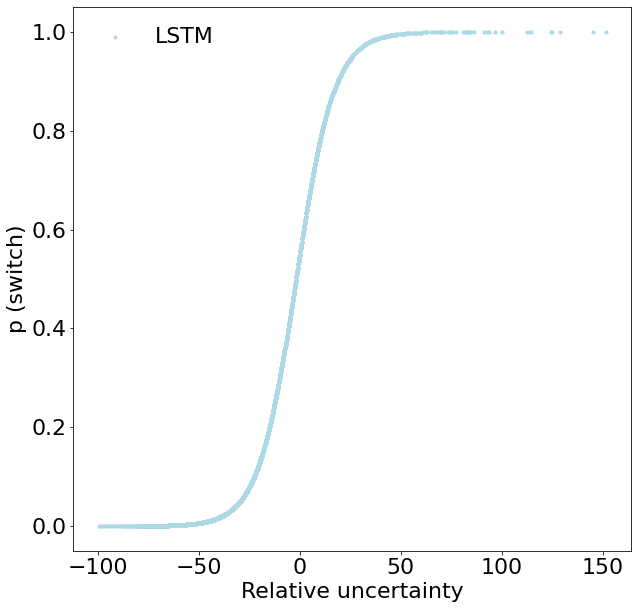

In [102]:
plt.scatter(lagged_unc_arr, y_lstm, color='lightblue', label = 'LSTM', marker='.')
#plt.plot(x_rel_rew, y_human, color='black', label = 'Human')
plt.ylabel('p (switch)')
plt.xlabel('Relative uncertainty')
plt.legend(frameon=False)

In [247]:
# create df
df = pd.DataFrame({'lagged_unc_ch': lagged_unc_arr, 'is_switch':switch_arr})

# create bins
df['rel_unc_bins'] = pd.qcut(df['lagged_unc_ch'], q=10000, duplicates = 'drop')

test_df = df.groupby(['rel_unc_bins']).mean()
test_df

,lagged_unc_ch,is_switch
rel_unc_bins,,
"(-99.501, -98.155]",-99.125,0.0
"(-98.155, -96.809]",-97.625,0.0
"(-96.809, -95.464]",-96.125,0.0
"(-95.464, -94.118]",-94.625,0.0
"(-94.118, -92.773]",-93.500,0.0
...,...,...
"(96.607, 110.305]",100.000,1.0
"(110.305, 114.155]",113.250,1.0
"(114.155, 124.706]",119.375,1.0


In [249]:
bin_x = np.zeros(np.shape(test_df)[0])

for i in range(np.shape(test_df)[0]):
    bin_x[i] = np.mean(np.array([test_df.index[i].left, test_df.index[i].right]))

In [250]:
test_df['mean_bin_vals'] = bin_x


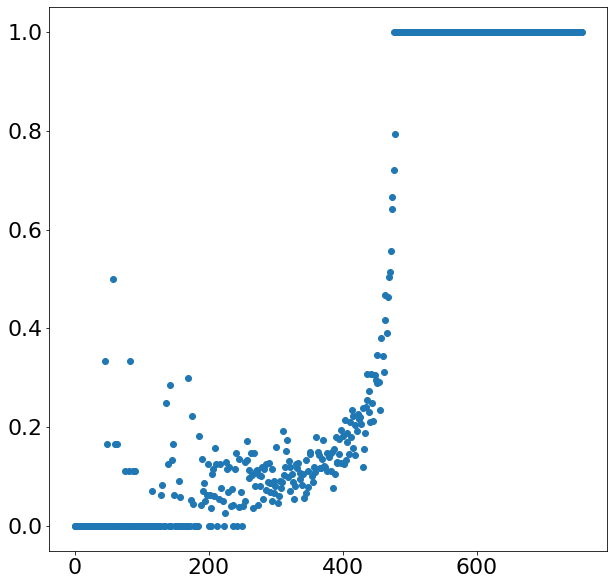

In [253]:
plt.scatter(range(np.shape(test_df)[0]), test_df.is_switch)